In [1]:
import torch
import torch.nn as nn
from torchsummary import summary
import torchvision
from tqdm.auto import tqdm

import matplotlib.pyplot as plt   

# force re-import
%load_ext autoreload
%autoreload 2



/home/kbh/.conda/envs/dnn/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Hypter parameters

In [2]:
lastdigit=4
device = "cuda:0"
type_model = "AE"

modelsave_path = "."

batch_size = 1024
num_workers = 16
num_epochs = 50
lr = 1e-4

# Models

In [3]:
# Auto Encodoer

class model_AE(nn.Module):
    def __init__(self, input_size=784):
        super(model_AE, self).__init__()
        # 784, 256, 64, 36
        self.relu = nn.ReLU()
        self.sig = nn.Sigmoid()
        
        self.enc1 = nn.Linear(input_size,256)
        self.enc2 = nn.Linear(256,64)
        self.enc3 = nn.Linear(64,36)
        
        self.dec1 = nn.Linear(36,64)
        self.dec2 = nn.Linear(64,256)
        self.dec3 = nn.Linear(256,input_size)

    def forward(self, x):
        B,C,W,H = x.shape
        x = torch.reshape(x,(B,C,W*H))
        
        x = self.enc1(x)
        x = self.relu(x)
        x = self.enc2(x)
        x = self.relu(x)
        x = self.enc3(x)
        x = self.relu(x)
        
        x = self.dec1(x)
        x = self.relu(x)
        x = self.dec2(x)
        x = self.relu(x)
        x = self.dec3(x)
        x = self.sig(x)
        
        x = torch.reshape(x,(B,C,W,H))
        
        return x
    
    def generate(self,x) :
        # x : [1,1,36]
           
        x = self.dec1(x)
        x = self.relu(x)
        x = self.dec2(x)
        x = self.relu(x)
        x = self.dec3(x)
        x = self.sig(x)
        
        x = torch.reshape(x,(28,28))
        
        return x

# Data

In [4]:
dataset_train = torchvision.datasets.MNIST(root = './data/',
                            train=True,
                            download=True,
                            transform=torchvision.transforms.ToTensor())
dataset_test = torchvision.datasets.MNIST(root = './data/',
                            train=False,
                            download=True,
                            transform=torchvision.transforms.ToTensor())

print("train : {} | test : {}".format(len(dataset_train),len(dataset_test)))

indices_train = [idx for idx, target in enumerate(dataset_train.targets) if target != lastdigit]
indices_test = [idx for idx, target in enumerate(dataset_test.targets) if target != lastdigit]

print("Filter by lastdigit {}".format(lastdigit))

dataset_train = torch.utils.data.Subset(dataset_train,indices_train)
dataset_test = torch.utils.data.Subset(dataset_test,indices_test)

print("train : {} | test : {}".format(len(dataset_train),len(dataset_test)))

loader_train = torch.utils.data.DataLoader(dataset=dataset_train,batch_size=batch_size,shuffle=True,num_workers=num_workers,pin_memory=True)
loader_test = torch.utils.data.DataLoader(dataset=dataset_test,batch_size=batch_size,shuffle=True,num_workers=num_workers,pin_memory=True)



train : 60000 | test : 10000
Filter by lastdigit 4
train : 54158 | test : 9018


# Train routines

In [5]:
def run(
    data,
    model,
    criterion=None,
    ret_output=False,
    device="cuda:0"
    ): 
    feature = data[0].to(device)
    
    estim = model(feature)
    
    target = feature
                                   
    if criterion is None : 
        return estim
    loss = criterion(estim,target)
        
    if ret_output :
        return estim, loss
    else : 
        return loss


In [6]:
def train() : 
    model = model_AE()
    summary(model,(1,28,28),device = "cpu")
    model = model.to(device)
    criterion = nn.BCELoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer)

    log_train = []
    log_test  = []

    best_loss = 1e13

    for epoch in tqdm(range(num_epochs)):
        model.train()
        train_loss = 0.0
        for i, data in enumerate(loader_train):
            loss = run(data,model,criterion,device=device)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
        train_loss = train_loss/len(loader_train)
        torch.save(model.state_dict(), str(modelsave_path)+'/{}_lastmodel.pt'.format(type_model))

        log_train.append(train_loss)

        model.eval()
        with torch.no_grad():
            test_loss =0.
            for j, (data) in enumerate(loader_test):
                gen, loss = run(data,model,criterion,ret_output=True,device=device)
                test_loss += loss.item()

            test_loss = test_loss/len(loader_test)
            scheduler.step(test_loss)

            if best_loss > test_loss:
                torch.save(model.state_dict(), str(modelsave_path)+'/{}_bestmodel.pt'.format(type_model))
                best_loss = test_loss

        log_test.append(test_loss)

    plt.figure()
    plt.plot(log_train)
    plt.title("train loss")

    plt.figure()
    plt.plot(log_test)
    plt.title("test loss")
    
    return model

In [7]:
def eval(model) : 
    model.eval()
    plt.figure(figsize=(6, 6))

    n_plot = 5
    idx_plot = 1

    for i in range(5*5) : 
        x = dataset_test[i][0].to(device)
        x = torch.unsqueeze(x,dim=0)
        y = model(x)

        plt.subplot(n_plot,n_plot,idx_plot)
        plt.imshow(y[0,0].detach().cpu().numpy(),cmap='gray_r')
        plt.axis('off')

        idx_plot+=1

# Train

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 1, 256]         200,960
              ReLU-2               [-1, 1, 256]               0
            Linear-3                [-1, 1, 64]          16,448
              ReLU-4                [-1, 1, 64]               0
            Linear-5                [-1, 1, 36]           2,340
              ReLU-6                [-1, 1, 36]               0
            Linear-7                [-1, 1, 64]           2,368
              ReLU-8                [-1, 1, 64]               0
            Linear-9               [-1, 1, 256]          16,640
             ReLU-10               [-1, 1, 256]               0
           Linear-11               [-1, 1, 784]         201,488
          Sigmoid-12               [-1, 1, 784]               0
Total params: 440,244
Trainable params: 440,244
Non-trainable params: 0
-------------------------------

100%|████████████████████████████████████████████████████████████████████████████████| 50/50 [01:52<00:00,  2.26s/it]


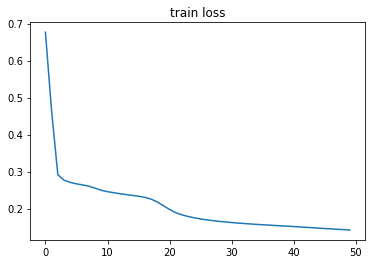

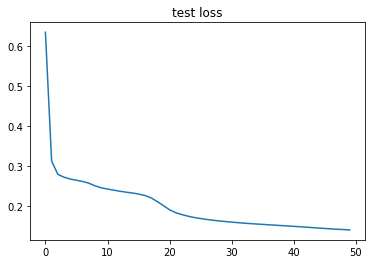

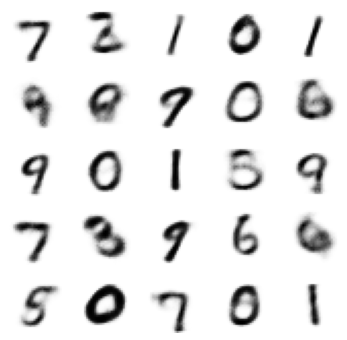

In [8]:
model = train()
eval(model)